# Drone Delivery Assignment Problem Simulator

This notebook implements a simulation system for optimizing drone delivery task assignments.

## Objectives
- Optimize task allocation among multiple delivery drones
- Analyze and evaluate performance through simulation

## Required Modules
- `dronesim`: Simulation framework for drone operations
- `DeliveryTask`: Task management for delivery operations  
- `DeliveryDrone`: Drone modeling and control
- `numpy`: Numerical computing library

In [109]:
# Import required modules for drone simulation
from dronesim import Simulator
from dronesim.energy import WattHour
from dronesim.energy.battery import BatteryStatus
from dronesim.geo import GeoPoint, Latitude, Longitude
from dronesim.mission import DeliveryTask
from dronesim.unit import ClockTime, Hour, Kilometer, KilometersPerHour, Minute, Time, Watt
from dronesim.vehicles import DeliveryDrone

DATA_CSV_FILE = "./train.csv"
EXPECT_CSV_FILE = "./train.csv"
CLUSTER_DATA_FILE = "./train.csv"

# DATA_CSV_FILE = "./test.csv"
# EXPECT_CSV_FILE = "./Sample_Submission.csv"
# CLUSTER_DATA_FILE = "./train.csv"

N_CLUSTERS = 10
WAITING_TIME = Minute(0.1)
DT = Minute(0.1)
DRONE_COUNT = 150
J = 1
BATCH_SIZE = 100

DRONE_VELOCITY = KilometersPerHour(60)
BATTERY_CAPACITY = WattHour(500)
BATTERY_CURRENT = WattHour(500)
OPERATIONAL_BATTERY_PERCENTAEG = 20

IDLE_POWER = Watt(10)
VTOL_POWER = Watt(500)
TRAINSIT_POWER = Watt(500)
PER_PACAGE_POWER = Watt(100)

TASK_QUEUE_PER_DRONE=2
DELVIERYS_PER_CHARGE=2





print("All modules imported successfully!")

All modules imported successfully!


## Implement Delivery Drone Assignments Problem Simulator


In [110]:
# Define the main simulation class for drone assignments
class DroneAssignmentsProblemSimulator(Simulator[DeliveryDrone, DeliveryTask]):
    target_city : str
    target_center: GeoPoint
    target_geo_range: Kilometer
    drone_count: int
    cluster_data_path: str
    cluster: int

    def __init__(self,cluster_data_path: str, drone_count: int = 50, cluster:int =1) -> None:
        super().__init__()
        self.target_city = "Metropolitian"

        self.cluster_data_path = cluster_data_path
        self.cluster = cluster
        self._is_clustering_done = False

        target_res_lat = Latitude(12.959861)  # Example latitude for restaurant
        target_res_lon = Longitude(77.579225)  # Example longitude for restaurant
        self.target_center = GeoPoint(target_res_lat, target_res_lon)

        self.target_geo_range = Kilometer(50)  # 50 km range
        self.drone_count = drone_count

    def make_task(self, columns: list[str], row: list[str]) -> DeliveryTask | None:
        """Create a delivery task from CSV data row."""
        if "NaN" in row:
            return None

        restaurant_lat = Latitude(float(row[columns.index("Restaurant_latitude")]))
        restaurant_lon = Longitude(float(row[columns.index("Restaurant_longitude")]))

        delivery_lat = Latitude(float(row[columns.index("Delivery_location_latitude")]))
        delivery_lon = Longitude(float(row[columns.index("Delivery_location_longitude")]))


        origin = GeoPoint(
            restaurant_lat, restaurant_lon
        )
        destination = GeoPoint(
            delivery_lat, delivery_lon
        )
        if origin.distance_to(self.target_center) > self.target_geo_range:
            return None
        if destination.distance_to(self.target_center) > self.target_geo_range:
            return None

        request_time = ClockTime.from_str(row[columns.index("Time_Orderd")])
        if request_time < Hour(3):
            request_time += Hour(24)

        pickup_time = ClockTime.from_str(row[columns.index("Time_Order_picked")])
        id = int(row[columns.index("ID")], 16)
        return DeliveryTask(
            origin=origin,
            destination=destination,
            order_time=request_time,
            pickup_time=pickup_time,
            id=id,
        )

    def _get_bases(self, cluster:int) -> list[tuple[GeoPoint, float]]:
        """Get clustering bases using simple K-means instead of KMedoids to avoid haversine issues."""
        if self._is_clustering_done:
            return self._cached_bases

        try:
            import numpy as np
            from sklearn.cluster import KMeans

            tasks = self.parse_task_data(self.cluster_data_path, key=None)

            # Extract lat/lon coordinates
            points = np.array([[float(task.origin.latitude), float(task.origin.longitude)] for task in tasks])
            print(f"Clustering {len(points)} points into {self.cluster} clusters")

            # Use simple K-means with Euclidean distance (good enough for small geographic areas)
            kmeans = KMeans(n_clusters=min(self.cluster, len(points)), random_state=42, n_init=10)
            labels = kmeans.fit_predict(points)
            centers = kmeans.cluster_centers_

            retval = []
            for i, center in enumerate(centers):
                count = sum(1 for label in labels if label == i)
                if count > 0:  # Only include clusters with actual points
                    latitude = Latitude.from_si(center[0])
                    longitude = Longitude.from_si(center[1])
                    retval.append((GeoPoint(latitude, longitude), count))

            self._cached_bases = retval
            self._is_clustering_done = True
            print(f"Successfully created {len(retval)} cluster bases: ")
            for base, count in retval:
                print(f'({base.latitude}, {base.longitude}) - Store Count: {count}')
            return retval

        except Exception as e:
            print(f"Clustering failed: {e}")
            # Simple fallback: create evenly spaced points around the center
            retval = []
            for i in range(self.cluster):
                # Create points in a circle around the center
                angle = (2 * np.pi * i) / self.cluster
                offset_lat = 0.01 * np.cos(angle)  # Small offset ~1km
                offset_lon = 0.01 * np.sin(angle)

                lat = float(self.target_center.latitude) + offset_lat
                lon = float(self.target_center.longitude) + offset_lon

                retval.append((GeoPoint(Latitude(lat), Longitude(lon)), 100))  # Assume equal distribution

            self._cached_bases = retval
            self._is_clustering_done = True
            return retval

    def make_vehicle(self):
        """Generate delivery drone instances for the simulation fleet."""
        try:
            bases = self._get_bases(self.cluster)
            total_tasks = sum(count for _, count in bases)

            if total_tasks == 0:
                # Fallback: create all drones at center if clustering fails
                for i in range(self.drone_count):
                    yield DeliveryDrone(
                        pos=self.target_center,
                        velocity=DRONE_VELOCITY,
                        battery=BatteryStatus(
                            capacity=BATTERY_CAPACITY,
                            current=BATTERY_CURRENT
                        ),
                        power_idle=IDLE_POWER,
                        power_vtol=VTOL_POWER,
                        power_transit=TRAINSIT_POWER,
                        power_per_pakage=PER_PACAGE_POWER,
                        deliveries_per_charge=DELVIERYS_PER_CHARGE,
                        max_task_queue_size=TASK_QUEUE_PER_DRONE,
                        operational_battery_percentage = OPERATIONAL_BATTERY_PERCENTAEG
                    )
                return

            drones_created = 0
            last_base = self.target_center

            for base, count in bases:
                # Calculate proportional drone count for this base
                base_drone_count = int((count / total_tasks) * self.drone_count)

                for i in range(base_drone_count):
                    if drones_created < self.drone_count:
                        yield DeliveryDrone(
                            pos=base,
                            velocity=DRONE_VELOCITY,
                            battery=BatteryStatus(
                                capacity=BATTERY_CAPACITY,
                                current=BATTERY_CURRENT
                            ),
                            power_idle=IDLE_POWER,
                            power_vtol=VTOL_POWER,
                            power_transit=TRAINSIT_POWER,
                            power_per_pakage=PER_PACAGE_POWER,
                            deliveries_per_charge=DELVIERYS_PER_CHARGE,
                            max_task_queue_size=TASK_QUEUE_PER_DRONE,
                            operational_battery_percentage = OPERATIONAL_BATTERY_PERCENTAEG
                        )
                        drones_created += 1

                last_base = base

            # Create remaining drones at the last base
            while drones_created < self.drone_count:
                yield DeliveryDrone(
                    pos=last_base,
                    velocity=DRONE_VELOCITY,
                    battery=BatteryStatus(
                        capacity=BATTERY_CAPACITY,
                        current=BATTERY_CURRENT
                    ),
                    power_idle=IDLE_POWER,
                    power_vtol=VTOL_POWER,
                    power_transit=TRAINSIT_POWER,
                    power_per_pakage=PER_PACAGE_POWER,
                    deliveries_per_charge=DELVIERYS_PER_CHARGE,
                    max_task_queue_size=TASK_QUEUE_PER_DRONE,
                    operational_battery_percentage = OPERATIONAL_BATTERY_PERCENTAEG
                )
                drones_created += 1

        except Exception as e:
            print(f"Warning: Clustering failed ({e}), using fallback drone creation")
            # Fallback: create all drones at center
            for i in range(self.drone_count):
                yield DeliveryDrone(
                    pos=self.target_center,
                    velocity=DRONE_VELOCITY,
                    battery=BatteryStatus(
                        capacity=BATTERY_CAPACITY,
                        current=BATTERY_CURRENT
                    ),
                    power_idle=IDLE_POWER,
                    power_vtol=VTOL_POWER,
                    power_transit=TRAINSIT_POWER,
                    power_per_pakage=PER_PACAGE_POWER,
                    deliveries_per_charge=DELVIERYS_PER_CHARGE,
                    max_task_queue_size=TASK_QUEUE_PER_DRONE,
                    operational_battery_percentage = OPERATIONAL_BATTERY_PERCENTAEG
                )

        return None

In [111]:
from dronesim.energy.unit import Energy
from dronesim.mission.task_delivery import DeliveryState
from dronesim.simulator import (
    analyze_task_processing_speed,
    analyze_task_processing_times,
    analyze_vehicle_battery_consumption,
)
from dronesim.unit.unit_time import Hour
import matplotlib.pyplot as plt


class SimPlot:
    def __init__(self, simulator: Simulator, sample_submission_csv: str| None =None):
        self.simulator = simulator
        self.sample_submission_csv = sample_submission_csv



    def deviation_in_time_taken(self):
        import csv

        tasks: list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플

        task_data = []
        traffic_data = []
        matched_count = 0
        total_tasks = len(tasks)

        print(f"Total simulation tasks: {total_tasks}")

        with open(self.sample_submission_csv) as f:
            reader = csv.reader(f)
            columns = next(reader)
            for row in reader:
                row = [cell.strip() for cell in row]
                row_id = int(row[columns.index("ID")], 16)

                # Find matching task
                task = None
                for t in tasks:
                    if t.id == row_id:
                        task = t
                        matched_count += 1
                        break

                if task is None:
                    continue

                # Check if task has required timing data
                if task.start_at is None or task.completed_at is None:
                    print(f"Task {task.id} missing timing data: start_at={task.start_at}, completed_at={task.completed_at}")
                    continue

                start_time = float(task.start_at)

                # Calculate simulation processing time (in minutes)
                sim_processing_time = (float(task.completed_at) - start_time)
                try:
                    request_time = ClockTime.from_str(row[columns.index("Time_Orderd")])
                    pickup_time = ClockTime.from_str(row[columns.index("Time_Order_picked")])
                    wating_time = float(pickup_time - request_time)
                except:
                    wating_time = float(Minute(10))
                if wating_time < 0:
                    wating_time = -(wating_time + float(Hour(24)))

                expected_time = float(row[columns.index("Time_taken(min)")]) * 60 + wating_time



                # Calculate deviation (expected - actual)
                time_deviation = expected_time - sim_processing_time

                task_data.append({
                    'start_time': start_time,
                    'processing_time': time_deviation
                })
                traffic = row[columns.index("Road_traffic_density")]
                traffic_data.append({
                    'start_time': start_time,
                    'congestion_level': traffic
                })

        # print(f"Matched tasks: {matched_count}")
        # print(f"Valid data points: {len(task_data)}")

        if len(task_data) == 0:
            print("No valid data found - checking first few tasks...")
            for i, task in enumerate(tasks[:5]):
                print(f"Task {i}: id={task.id}, start_at={task.start_at}, completed_at={task.completed_at}")

        return analyze_task_processing_times(task_data, "Time Deviation Analysis", traffic_data)


    def expected_time_analysis(self):
        """Analyze expected processing times from the sample submission CSV."""
        import csv

        tasks: list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플

        task_data = []
        traffic_data = []

        matched_count = 0
        total_tasks = len(tasks)

        with open(self.sample_submission_csv) as f:
            reader = csv.reader(f)
            columns = next(reader)
            for row in reader:
                row = [cell.strip() for cell in row]
                row_id = int(row[columns.index("ID")], 16)

                # Find matching task
                task = None
                for t in tasks:
                    if t.id == row_id:
                        task = t
                        matched_count += 1
                        break

                if task is None:
                    continue

                # Check if task has required timing data
                if task.start_at is None or task.completed_at is None:
                    continue

                # Get expected time from CSV (in minutes) and convert to seconds
                try:
                    request_time = ClockTime.from_str(row[columns.index("Time_Orderd")])
                    pickup_time = ClockTime.from_str(row[columns.index("Time_Order_picked")])
                    wating_time = float(pickup_time - request_time)
                except:
                    wating_time = float(Minute(10))


                if wating_time < 0:
                    wating_time = -(wating_time + float(Hour(24)))

                expected_time = float(row[columns.index("Time_taken(min)")]) * 60 + wating_time


                task_data.append({
                    'start_time': float(task.start_at),
                    'processing_time': expected_time  # Now in seconds for consistency
                })
                traffic = row[columns.index("Road_traffic_density")]
                traffic_data.append({
                    'start_time': float(task.start_at),
                    'congestion_level': traffic
                })

        # print(f"Expected time data points: {len(task_data)}")
        return analyze_task_processing_times(task_data, "Expected Time Analysis", traffic_data)


    def task_processing_times(self):
        tasks : list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플 언패킹 제거
        task_data = []
        for task in tasks:
            if task.start_at is not None and task.completed_at is not None:
                start_time = float(task.start_at)
                processing_time = float(task.completed_at) - start_time

                task_data.append({
                    'start_time': start_time,
                    'processing_time': processing_time
                })

        return analyze_task_processing_times(task_data, "Task Processing Time Analysis")

    def task_speed(self):
        tasks : list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플 언패킹 제거
        task_data = []
        for task in tasks:
            if task.start_at is not None and task.completed_at is not None:
                start_time = float(task.start_at)
                t = float(task.event_time[DeliveryState.SERVICE_DROPOFF]) - float(task.event_time[DeliveryState.SERVICE_PICKUP])
                speed = (float(task.origin.distance_to(task.destination))) / (t)  # km/h


                task_data.append({
                    'start_time': start_time,
                    'speed': speed
                })

        return analyze_task_processing_speed(task_data, "Task Processing Speed Analysis")

    def deviation_speed(self):
        import csv

        tasks: list[DeliveryTask]
        tasks, _ = self.simulator.results  # 메서드 호출, 튜플

        task_data = []
        traffic_data =[]
        matched_count = 0
        total_tasks = len(tasks)

        print(f"Total simulation tasks: {total_tasks}")

        with open(self.sample_submission_csv) as f:
            reader = csv.reader(f)
            columns = next(reader)
            for row in reader:
                row = [cell.strip() for cell in row]
                row_id = int(row[columns.index("ID")], 16)

                # Find matching task
                task = None
                for t in tasks:
                    if t.id == row_id:
                        task = t
                        matched_count += 1
                        break

                if task is None:
                    continue

                # Check if task has required timing data
                if task.start_at is None or task.completed_at is None:
                    print(f"Task {task.id} missing timing data: start_at={task.start_at}, completed_at={task.completed_at}")
                    continue

                start_time = float(task.start_at)

                # Calculate simulation processing time (in minutes)
                sim_delivery_time = (float(task.event_time[DeliveryState.SERVICE_DROPOFF]) - float(task.event_time[DeliveryState.SERVICE_PICKUP]))
                # Get expected time from CSV (already in minutes)

                expected_time = float(row[columns.index("Time_taken(min)")]) * 60

                distance = float(task.origin.distance_to(task.destination))
                epceted_speed = distance / expected_time
                sim_speed = distance / sim_delivery_time

                # Calculate deviation (expected - actual)
                speed = sim_speed - epceted_speed

                task_data.append({
                    'start_time': start_time,
                    'speed': speed
                })
                traffic = row[columns.index("Road_traffic_density")]
                traffic_data.append({
                    'start_time': float(task.start_at),
                    'congestion_level': traffic
                })

        # print(f"Matched tasks: {matched_count}")
        # print(f"Valid data points: {len(task_data)}")

        if len(task_data) == 0:
            print("No valid data found - checking first few tasks...")
            for i, task in enumerate(tasks[:5]):
                print(f"Task {i}: id={task.id}, start_at={task.start_at}, completed_at={task.completed_at}")

        return analyze_task_processing_speed(task_data, "Speed Deviation Analysis", traffic_data)

    def battery_usage(self):
        tasks: list[DeliveryTask]
        vehicles: list[DeliveryDrone]
        tasks, vehicles = self.simulator.results  # 메서드 호출, 튜플
        battery_usage_history: list[tuple[Time, Time, Energy]] = []
        vehicle_data = []
        for history in [vehicle.battery_usage_history for vehicle in vehicles]:
            battery_usage_history += history

        for battery_usage in battery_usage_history:
            vehicle_data.append({
                'start_time': float(battery_usage[0]),
                'battery_used': float(battery_usage[2])
            })

        return analyze_vehicle_battery_consumption(vehicle_data, "Vehicle Battery Consumption Analysis")


    def show(self):
        plt.show()




## Fair Drone Assignment Strategy - Round-Robin Algorithm

### Algorithm Type: **Round-Robin Scheduling/Load Balancing**

The Fair Drone Assignment Strategy implements a **Round-Robin Load Balancing Algorithm** that ensures equitable task distribution among all drones in the fleet.

### How it works:
1. **Cyclic Assignment**: The algorithm maintains a counter (`drone_i`) that cycles through all available drones in sequential order
2. **Time-Based Batching**: Tasks are processed in batches at regular intervals (default: 1 minute waiting time)
3. **Fair Distribution**: Each drone gets assigned tasks in turn, ensuring equal workload distribution

### Key Characteristics:

**Fairness**: 
- Each drone receives an equal number of tasks over time
- No drone is overloaded while others remain idle
- Ensures balanced resource utilization across the fleet

**Simplicity**: 
- No complex optimization calculations required
- O(1) time complexity for task assignment
- Easy to implement and maintain

**Predictability**: 
- Deterministic assignment pattern
- Each drone knows it will receive tasks in regular intervals

### Algorithm Steps:
1. Wait for the specified time interval (`waiting_time`)
2. Get all pending delivery tasks
3. For each task:
   - Assign to the current drone (`drone_i`)
   - If assignment fails (drone is full), stop processing
   - Move to next drone: `drone_i = (drone_i + 1) % total_drones`
4. Repeat the cycle

### Use Cases:
- **Fair resource allocation** in multi-drone systems
- **Load balancing** for delivery services
- **Equal opportunity scheduling** where fairness is prioritized over optimization
- Scenarios where **simple, predictable behavior** is preferred over complex optimization

### Trade-offs:
**Advantages:**
- Guarantees fairness and equal workload
- Simple implementation and debugging
- Predictable system behavior

**Disadvantages:**
- May not be optimal for distance/time efficiency
- Doesn't consider drone proximity to tasks
- May result in longer delivery times compared to location-based algorithms

This algorithm is ideal when you want to ensure **equitable workload distribution** among drones rather than optimizing for shortest delivery times or distances.from dronesim.unit import Minute

In [112]:
class FairDroneAssignmentStrategy(DroneAssignmentsProblemSimulator):
    drone_i: int
    current: Time

    def __init__(self, drone_count: int = 50, wating_time: Time = Minute(1)):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.drone_i = 0
        self.current = wating_time
        self.wating_time = wating_time

    def sim_update(self, dt, now):
        """Update the simulation state by a time step."""
        if now < self.current:
            return
        self.current += self.wating_time

        for task in self.get_pending_tasks():
            if not self.get_vehicles()[self.drone_i].assign(task):
                self.failed_to_assign_task(task)
                break
            self.drone_i = (self.drone_i + 1) % len(self.get_vehicles())


    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass


In [113]:
# # Run Fair Drone Assignment Strategy simulation
# fair_sim = FairDroneAssignmentStrategy(DRONE_COUNT, wating_time=WATING_TIME)
# fair_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT)
# p = SimPlot(fair_sim, EXPECT_CSV_FILE)
# p.task_processing_times()
# p.expected_time_analysis()
# p.deviation_in_time_taken()
# p.task_speed()
# p.deviation_speed()
# p.show()


## Nearest Drone Assignment Strategy - Greedy Distance-Based Algorithm

### Algorithm Type: **Greedy Nearest Neighbor Assignment**

The Nearest Drone Assignment Strategy implements a **Distance-Based Greedy Algorithm** that assigns each task to the closest available drone based on geographical proximity to the task's origin point.

### How it works:
1. **Distance Calculation**: For each incoming task, calculate the distance from `task.origin` to all available drones
2. **Greedy Selection**: Select the drone with the minimum distance to the task's pickup location
3. **Immediate Assignment**: Assign the task to the nearest drone without considering global optimization
4. **Real-time Processing**: Tasks are processed as they arrive in the system

### Key Characteristics:

**Efficiency**: 
- Minimizes travel distance for pickup operations
- Reduces fuel consumption and delivery time
- Optimal for immediate response scenarios

**Simplicity**: 
- Straightforward distance-based decision making
- O(n) time complexity where n = number of available drones
- Easy to understand and implement

**Locality**: 
- Prioritizes geographical proximity
- Natural clustering of drone operations
- Efficient use of local drone resources

### Algorithm Steps:
1. Receive a new delivery task
2. Calculate distance from `task.origin` to each available drone's current position
3. Find the drone with minimum distance: `min(distance(drone.position, task.origin))`
4. Assign the task to the nearest drone if it has capacity
5. If nearest drone is full, try the next nearest drone
6. Repeat for all incoming tasks

### Use Cases:
- **Time-critical deliveries** where pickup speed is essential
- **Fuel-efficient operations** to minimize operational costs
- **Urban delivery services** with high task density
- **Emergency response** scenarios requiring immediate dispatch
- **Resource optimization** based on geographical distribution

### Trade-offs:
**Advantages:**
- Minimizes travel time and distance
- Reduces operational costs (fuel, battery)
- Simple and intuitive decision making
- Good performance for locally clustered tasks

**Disadvantages:**
- May create uneven workload distribution among drones
- Can lead to some drones being overworked while others are idle
- Doesn't consider future task arrivals or global optimization
- May not be optimal for long-term system efficiency

### Mathematical Foundation:
```
For task T with origin O, select drone D where:
D* = argmin(distance(D.position, T.origin)) for all available drones D
```

This algorithm is ideal when **minimizing delivery response time** and **operational costs** are more important than ensuring perfectly balanced workload distribution among the drone fleet.

In [114]:
class NearestDroneAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """Nearest Drone Assignment Strategy implementing Greedy Distance-Based Algorithm.
    Assigns each task to the closest available drone based on geographical proximity.
    """

    def __init__(self, drone_count: int = 50, wating_time: Time = Minute(1)):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.current = wating_time
        self.wating_time = wating_time

    def sim_update(self, dt, now):
        """Update the simulation state by assigning tasks to nearest available drones."""
        if now < self.current:
            return
        self.current += self.wating_time

        for task in self.get_pending_tasks():
            # Find the nearest available drone to the task's origin
            nearest_drone = self._find_nearest_drone(task)

            if nearest_drone is not None:
                # Try to assign the task to the nearest drone
                if not nearest_drone.assign(task):
                    # If nearest drone is full, try other drones in order of distance
                    if not self._assign_to_alternative_drone(task):
                        self.failed_to_assign_task(task)
                        break
            else:
                self.failed_to_assign_task(task)
                break

    def _find_nearest_drone(self, task: DeliveryTask):
        """Find the drone with minimum distance to the task's origin."""
        # Only consider operational drones (not full and has battery)
        available_drones = [drone for drone in self.get_vehicles() if drone.can_accept_task()]

        if not available_drones:
            return None

        # Calculate distances and find the nearest drone
        min_distance = None
        nearest_drone = None

        for drone in available_drones:
            distance = drone.position.distance_to(task.origin)
            if min_distance is None or distance < min_distance:
                min_distance = distance
                nearest_drone = drone

        return nearest_drone

    def _assign_to_alternative_drone(self, task: DeliveryTask):
        """Try to assign task to alternative drones if nearest is unavailable."""
        # Get all operational drones sorted by distance to task origin
        available_drones = [drone for drone in self.get_vehicles() if drone.can_accept_task()]
        drone_distances = []

        for drone in available_drones:
            distance = drone.position.distance_to(task.origin)
            drone_distances.append((drone, distance))

        # Sort by distance (ascending) - using float conversion for sorting
        drone_distances.sort(key=lambda x: float(x[1]))

        # Try to assign to drones in order of proximity
        for drone, _ in drone_distances:
            if drone.assign(task):
                return True
        return False

    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

In [115]:
# # Run Nearest Drone Assignment Strategy simulation
# nearest_sim = NearestDroneAssignmentStrategy(DRONE_COUNT, wating_time=WATING_TIME)
# nearest_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT)
# p_nearest = SimPlot(nearest_sim, EXPECT_CSV_FILE)
# p_nearest.task_processing_times()
# p_nearest.expected_time_analysis()
# p_nearest.deviation_in_time_taken()
# p_nearest.task_speed()
# p_nearest.deviation_speed()
# p_nearest.show()

In [116]:
# Nearest Strategy - Expected Time Analysis
# p_nearest.expected_time_analysis()

## Optimal Distance Assignment Strategy - Smart Route Optimization Algorithm

### Algorithm Type: **Dynamic Route Optimization with Total Distance Minimization**

The Optimal Distance Assignment Strategy implements a **Smart Route Optimization Algorithm** that considers not only the distance to the new task's pickup location, but also the total additional travel distance when the new task is integrated into each drone's existing task queue.

### How it works:
1. **Queue Analysis**: For each drone, analyze its current task queue and planned route
2. **Route Integration**: Calculate the optimal insertion point for the new task in each drone's route
3. **Distance Calculation**: Compute the total additional distance required when inserting the new task
4. **Optimal Selection**: Choose the drone that results in the minimum total additional travel distance
5. **Dynamic Insertion**: Insert the task at the optimal position in the selected drone's queue

### Key Characteristics:

**Intelligence**: 
- Considers existing workload and routing context
- Optimizes for total system efficiency rather than just proximity
- Dynamically adapts to current operational state

**Efficiency**: 
- Minimizes total fleet travel distance
- Reduces overall fuel consumption and delivery time
- Optimizes resource utilization across the entire system

**Adaptability**: 
- Adjusts decisions based on real-time drone states
- Considers current task queues and planned routes
- Responds to varying operational conditions

### Algorithm Steps:
1. Receive a new delivery task T
2. For each operational drone D:
   - Get current task queue: [T₁, T₂, ..., Tₙ]
   - Calculate current planned route distance: `route_distance(current_queue)`
   - For each possible insertion position i (0 to n+1):
     - Create new queue: [T₁, ..., Tᵢ, T, Tᵢ₊₁, ..., Tₙ]
     - Calculate new route distance: `route_distance(new_queue)`
     - Compute additional distance: `additional_distance = new_route - current_route`
   - Record minimum additional distance for drone D
3. Select drone with minimum additional distance: `D* = argmin(additional_distance(D, T))`
4. Insert task T at the optimal position in D*'s queue

### Use Cases:
- **Fleet optimization** where total operational cost is critical
- **High-density delivery services** with multiple concurrent tasks per drone
- **Resource-constrained environments** where efficiency is paramount
- **Complex urban delivery networks** with varying distances and traffic patterns
- **Long-term operational optimization** focusing on system-wide performance

### Mathematical Foundation:
```
For task T and drone D with current queue Q = [T₁, T₂, ..., Tₙ]:

Current route distance:
R(Q) = distance(drone_pos, T₁) + Σ(distance(Tᵢ.destination, Tᵢ₊₁.origin)) + distance(Tₙ.destination, drone_pos)

For insertion at position i:
Q' = [T₁, ..., Tᵢ, T, Tᵢ₊₁, ..., Tₙ]
Additional distance = R(Q') - R(Q)

Optimal assignment:
D* = argmin(min_insertion_position(additional_distance(D, T))) for all drones D
```

### Trade-offs:
**Advantages:**
- Globally optimized route planning
- Minimizes total system operational costs
- Considers real-time operational context
- Better long-term efficiency than greedy approaches
- Intelligent task queue management

**Disadvantages:**
- Higher computational complexity O(n×m×k) where n=drones, m=avg_queue_size, k=insertion_positions
- More complex implementation and debugging
- May have longer initial response times due to optimization calculations
- Requires maintaining detailed state information for all drones

### Comparison with Other Strategies:

**vs Fair Assignment:**
- More efficient but potentially less balanced workload
- Considers route optimization vs simple round-robin

**vs Nearest Assignment:**
- More intelligent but computationally more expensive
- Considers entire route context vs just pickup proximity

**vs All Strategies:**
- Highest optimization potential for total system efficiency
- Best suited for scenarios where operational cost minimization is the primary goal

This algorithm is ideal when **minimizing total operational costs** and **maximizing system-wide efficiency** are more important than simplicity or guaranteed workload balance. It's particularly effective in scenarios with high task density and complex routing requirements.

In [ ]:
class OptimalDistanceAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """Nearest Drone Assignment Strategy implementing Greedy Distance-Based Algorithm.
    Assigns each task to the closest available drone based on geographical proximity.
    """

    def __init__(self, drone_count: int = 50, wating_time: Time = Minute(1)):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.current = wating_time
        self.wating_time = wating_time

    def sim_update(self, dt, now):
        """Update the simulation state by assigning tasks to nearest available drones."""
        if now < self.current:
            return
        self.current += self.wating_time

        for task in self.get_pending_tasks():
            # Find the nearest available drone to the task's origin
            if not self._find_optimal_drone(task):
                self.failed_to_assign_task(task)
                break

    def _find_optimal_drone(self, task: DeliveryTask):
        """Find the drone with minimum distance to the task's origin."""
        # Only consider operational drones (not full and has battery)
        available_drones = [drone for drone in self.get_vehicles() if drone.can_accept_task()]
        if len(available_drones) == 0:
            return False

        drone_distances = []

        for drone in available_drones:
            distance, last_point = drone.estimate_mission_budget(task)
            d_distance = distance - drone.estimate_mission_budget()[0]
            drone_distances.append((drone, distance, d_distance))

        # Sort by distance (ascending) - using float conversion for sorting
        drone_distances.sort(key=lambda x: float(x[1]))

        # Try to assign to drones in order of proximity
        for drone, _, d_distance in drone_distances:
            if drone.assign(task):
                return True
        return False

    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

In [118]:
# # Run Optimal Distance Assignment Strategy simulation
# optimal_sim = OptimalDistanceAssignmentStrategy(DRONE_COUNT, wating_time=WAITING_TIME)
# optimal_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT, batch_size=BATCH_SIZE)
# p_optimal = SimPlot(optimal_sim, EXPECT_CSV_FILE)
# p_optimal.task_processing_times()
# p_optimal.expected_time_analysis()
# p_optimal.deviation_in_time_taken()
# p_optimal.task_speed()
# p_optimal.deviation_speed()
# p_optimal.battery_usage()
# p_optimal.show()

## MILP-Based Optimal Drone Assignment Strategy - Mathematical Optimization Algorithm

### Algorithm Type: **Mixed-Integer Linear Programming (MILP) Optimization**

The MILP-Based Optimal Drone Assignment Strategy implements a **Mathematical Optimization Algorithm** that formulates the drone-task assignment problem as a Mixed-Integer Linear Programming problem and finds the globally optimal solution using SciPy's optimization capabilities.

### Mathematical Formulation:

#### **Sets:**
- $I$: Set of available drones (drone fleet)
- $J$: Set of pending tasks (delivery requests)

#### **Parameters:**
- $\bar{d}_{ij} \geq 0$: Normalized total flight distance for drone $i$ to handle task $j$ (round-trip)
- $\bar{e}_{ij} \geq 0$: Normalized energy consumption (Wh) required for the assignment
- $\bar{A}_j \geq 0$: Normalized priority/value of task $j$
- $E_i^{\max} > 0$: Available battery capacity (Wh) for drone $i$
- $\sigma \in [0,1)$: Safety margin ratio (e.g., $\sigma=0.2$ reserves 20% battery)
- $w_{ij} \in \{0,1\}$: Distance gate (1 if task $j$ is within drone $i$'s operational range, 0 otherwise)
- $Q_i \in \mathbb{Z}^+$: Maximum concurrent tasks per drone $i$ (typically $Q_i = 1$)
- $\alpha, \beta, \gamma \geq 0$: Weight coefficients for distance, energy, and priority optimization terms
- $\rho_j \geq 0$: Penalty cost for dropping/deferring task $j$

#### **Normalization (for balanced optimization):**
- $\bar{d}_{ij} = \frac{d_{ij}}{D_{\max}}$: Distance normalized by maximum distance
- $\bar{e}_{ij} = \frac{e_{ij}}{E_i^{\max}}$: Energy normalized by drone's battery capacity
- $\bar{A}_j = \frac{A_j}{A_{\max}}$: Priority normalized by maximum task priority

#### **Decision Variables:**
- $x_{ij} \in \{0,1\}$: Binary assignment variable (1 if drone $i$ performs task $j$, 0 otherwise)
- $y_j \in \{0,1\}$: Binary drop variable (1 if task $j$ is dropped/deferred, 0 otherwise)

#### **Objective Function (Minimize):**

$$
\min \sum_{i \in I} \sum_{j \in J} \{\alpha \cdot \bar{d}_{ij} + \beta \cdot \bar{e}_{ij} - \gamma \cdot \bar{A}_j\} \cdot x_{ij} + \sum_{j \in J} \rho_j \cdot y_j
$$

**Interpretation:**
- $\alpha \cdot \bar{d}_{ij}$: Minimize total flight distances (operational efficiency)
- $\beta \cdot \bar{e}_{ij}$: Minimize energy consumption (battery optimization)
- $-\gamma \cdot \bar{A}_j$: Maximize task priority satisfaction (service quality)
- $\rho_j \cdot y_j$: Penalize task drops (completion rate optimization)

#### **Constraints:**

1. **Assignment Constraint**: Each task must be either assigned to exactly one drone or dropped
   $$
   \forall j \in J: \sum_{i \in I} x_{ij} + y_j = 1
   $$

2. **Capacity Constraint**: Each drone cannot exceed its concurrent task limit
   $$
   \forall i \in I: \sum_{j \in J} x_{ij} \leq Q_i
   $$

3. **Battery Constraint**: Total energy consumption must respect safety margins
   $$
   \forall i \in I: \sum_{j \in J} e_{ij} \cdot x_{ij} \leq (1-\sigma) \cdot E_i^{\max}
   $$

4. **Range Constraint**: Tasks outside operational range cannot be assigned
   $$
   \forall i \in I, \forall j \in J: x_{ij} \leq w_{ij}
   $$

### Key Characteristics:

**Mathematical Optimality**: 
- Guarantees globally optimal solution within the mathematical model constraints
- Considers all objectives and constraints simultaneously for best overall assignment
- Provides optimality certificates and solution quality guarantees

**Multi-Objective Optimization**: 
- Balances competing objectives (distance, energy, priority) through weighted coefficients
- Supports flexible priority schemes via adjustable parameters $\alpha$, $\beta$, $\gamma$
- Handles task importance through priority values and drop penalties

**Constraint Satisfaction**: 
- Rigorously enforces physical limitations (battery, range, capacity)
- Handles infeasible scenarios gracefully through task dropping mechanism
- Ensures mathematical feasibility and operational safety

### Drop Decision Mechanism:

**Task Drop Criteria ($\rho_j$ - Drop Penalty):**

The drop penalty $\rho_j$ determines when it's acceptable to defer/drop a task. The optimizer automatically decides to drop task $j$ when:

$$
\rho_j < \min_{i \in I} \{\alpha \cdot \bar{d}_{ij} + \beta \cdot \bar{e}_{ij} - \gamma \cdot \bar{A}_j\}
$$

**Practical Interpretation:**
- **High $\rho_j$ (e.g., $\rho_j = 10.0$)**: Force assignment even if inefficient → High completion rate, potentially suboptimal routes
- **Medium $\rho_j$ (e.g., $\rho_j = 1.0$)**: Balance between completion and efficiency → Drops only clearly infeasible tasks
- **Low $\rho_j$ (e.g., $\rho_j = 0.1$)**: Prefer efficiency over completion → Drops marginally inefficient tasks

**Drop Scenarios:**
1. **Physical Infeasibility**: All drones lack battery, capacity, or range (forced drop regardless of $\rho_j$)
2. **Economic Infeasibility**: Assignment cost exceeds drop penalty (optimizer-driven drop)
3. **Resource Optimization**: Better to drop low-priority tasks and serve high-priority ones efficiently

**Recommended $\rho_j$ Settings:**
- **Mission-Critical**: $\rho_j = 100 \times \max(\alpha, \beta, \gamma)$ (virtually never drop)
- **Balanced**: $\rho_j = 2 \times (\alpha + \beta + \gamma)$ (drop only when significantly inefficient)
- **Efficiency-First**: $\rho_j = 0.5 \times (\alpha + \beta + \gamma)$ (aggressive dropping for optimal fleet utilization)

### SciPy Implementation Strategy:

**Problem Formulation:**
```python
from scipy.optimize import milp, LinearConstraint, Bounds
import numpy as np

# Construct objective coefficients vector c
# Construct constraint matrices A_eq, A_ub  
# Define bounds and integrality constraints
# Solve using milp() function
```

**Key Implementation Steps:**
1. **Parameter Calculation**: Compute $d_{ij}$, $e_{ij}$, $w_{ij}$ for all drone-task pairs
2. **Matrix Construction**: Build constraint matrices for equality and inequality constraints
3. **Variable Ordering**: Organize $x_{ij}$ and $y_j$ variables in consistent indexing scheme
4. **Solver Invocation**: Use `scipy.optimize.milp` with appropriate solver parameters
5. **Solution Parsing**: Extract assignment decisions from optimal solution vector

### Use Cases:

**Mission-Critical Operations**: 
- Emergency response scenarios requiring optimal resource allocation
- High-value delivery services where solution quality justifies computation cost
- Military or medical drone operations with strict operational constraints

**Resource-Constrained Environments**: 
- Limited battery capacity requiring careful energy management
- Fleet operations with heterogeneous drone capabilities
- Operations in challenging geographical or regulatory environments

**Multi-Objective Scenarios**: 
- Balancing operational cost, service quality, and completion rates
- Optimizing for both immediate efficiency and long-term sustainability
- Complex prioritization schemes with varying task importance levels

### Algorithm Steps:
1. **State Assessment**: Evaluate current drone positions, battery levels, and task queues
2. **Parameter Computation**: Calculate distance, energy, and feasibility parameters for all drone-task pairs
3. **MILP Formulation**: Construct objective function and constraint matrices
4. **Optimization**: Solve MILP using SciPy's `milp` solver with appropriate time limits
5. **Solution Execution**: Implement optimal assignments and handle dropped tasks
6. **Monitoring**: Track solution quality and computational performance for tuning

### Trade-offs:

**Advantages:**
- **Guaranteed Optimality**: Mathematical proof of solution quality within model assumptions
- **Comprehensive Constraint Handling**: Rigorous enforcement of all operational limitations
- **Flexible Objective Function**: Supports complex multi-criteria optimization scenarios
- **Robust Infeasibility Handling**: Graceful management of impossible assignment scenarios
- **Scalable Parameter Tuning**: Easy adjustment of optimization priorities through weight parameters

**Disadvantages:**
- **Computational Complexity**: Potentially exponential solution time for large problem instances
- **Real-time Limitations**: May require solution time limits for time-critical applications
- **Implementation Complexity**: Requires mathematical optimization expertise and careful debugging
- **Modeling Assumptions**: Solution quality depends on accuracy of distance/energy models
- **Scalability Constraints**: Performance degrades with very large drone fleets or task sets

### Comparison with Heuristic Strategies:

**vs Fair Assignment (Round-Robin):**
- **Quality**: Optimal vs guaranteed fairness
- **Efficiency**: Minimized operational cost vs balanced workload
- **Complexity**: High computational cost vs O(1) assignment time

**vs Nearest Assignment (Greedy):**
- **Quality**: Global optimization vs local distance minimization
- **Constraints**: Full constraint satisfaction vs simple feasibility checks
- **Scalability**: Solver-dependent vs linear time complexity

**vs Optimal Distance (Route-based):**
- **Scope**: Multi-objective optimization vs single distance criterion
- **Constraints**: Mathematical constraint handling vs heuristic feasibility
- **Guarantees**: Provable optimality vs approximate solutions

This algorithm is ideal when **mathematical optimality** and **rigorous constraint satisfaction** are essential requirements, particularly in high-stakes scenarios where the value of optimal decisions significantly exceeds the computational investment required to achieve them.

In [119]:
# MILP Optimization Hyperparameters
# Objective Function Weight Coefficients




ALPHA, BETA, GAMMA = 3.0, 1.0, 2  # Distance, Energy, Priority weights

# Constraint Parameters
SIGMA = 0.2  # Safety margin ratio (reserves 20% of battery capacity)

# Solver Parameters
TIME_LIMIT = 60.0      # Solver time limit in seconds
MIP_REL_GAP = 1e-3    # Relative optimality gap

# Drop Penalty Configuration
# ⚠️ IMPORTANT: RHO should be calibrated based on normalized cost range!
# Normalized assignment cost range: [-GAMMA, ALPHA+BETA] = [-1.5, 3.0]
#
# RHO Calibration Guide:
# - RHO = 0.8 * (ALPHA + BETA + GAMMA) = 3.6  → Drop if cost > 3.6 (very aggressive, max efficiency)
# - RHO = 1.0 * (ALPHA + BETA + GAMMA) = 4.5  → Drop if cost > 4.5 (efficiency-first) ✅ RECOMMENDED
# - RHO = 1.2 * (ALPHA + BETA + GAMMA) = 5.4  → Drop if cost > 5.4 (balanced)
# - RHO = 1.5 * (ALPHA + BETA + GAMMA) = 6.75 → Drop if cost > 6.75 (conservative, rarely drops)
# - RHO = 2.0 * (ALPHA + BETA + GAMMA) = 9.0  → Almost never drop (force assignment)
#
# Note: Since max normalized cost = ALPHA + BETA = 3.0,
#       RHO > 3.0 means "always assign unless physically impossible"

RHO = 1.3 * ((ALPHA + BETA + GAMMA) ** 0.5)  # Efficiency-first: drops inefficient tasks ✅

# TASK_BATCH_SIZE = int(sqrt(DRONE_COUNT))  # Optimal batch size for 230 drones (√230 ≈ 15, use 2-3x)
TASK_BATCH_SIZE = 0  # Optimal batch size for 230 drones (√230 ≈ 15, use 2-3x)
TASKS_COUNT_PER_ASSIGNMNETS = 1
BASE_RETURN_WEIGHT = 0.5

TASK_QUEUE_PER_DRONE=10
DELVIERYS_PER_CHARGE=10
WAITING_TIME = Minute(1)  # Longer wait = better batching = better optimization

# Option 2: Task-specific penalty based on characteristics
# rho_j can be calculated per task based on:
# - Task priority/urgency
# - Customer tier/service level
# - Delivery time window constraints
# - Distance from depot
#
# Example implementations:
# rho_j = base_penalty * priority_multiplier
# rho_j = base_penalty * (1 + urgency_factor)
# rho_j = base_penalty * (2.0 if is_premium_customer else 1.0)

# Recommended Drop Penalty Strategies:
# 1. Max Efficiency: rho = 0.8-1.0 * (alpha + beta + gamma) - aggressively drop inefficient tasks ✅
# 2. Balanced: rho = 1.2-1.5 * (alpha + beta + gamma) - drop only clearly inefficient tasks
# 3. High Completion: rho = 2.0+ * (alpha + beta + gamma) - virtually never drop

## MILP Strategy Implementation

The following section implements the MILP-based drone assignment strategy using SciPy's optimization solver.

In [120]:
from __future__ import annotations

import numpy as np
from scipy.optimize import Bounds, LinearConstraint, milp


def build_milp_problem(n_drone, n_task, d_bar, e_bar, a_bar, e, w, Q, E, rho = None):
    """Build complete MILP problem: objective, bounds, and constraints."""
    n_drones = n_drone
    n_tasks = n_task
    n_x = n_drones * n_tasks  # x_{ij} variables
    n_y = n_tasks             # y_j variables
    n_total = n_x + n_y

    # Helper functions for variable indexing
    def idx_x(i, j): return i * n_tasks + j
    def idx_y(j): return n_x + j

    # Normalize parameters for numerical stability
    # d_max = max(np.max(data['d']), 1.0)
    # a_max = max(np.max(data['priority']), 1.0)
    # battery_safe = np.where(data['battery_capacity'] > 0, data['battery_capacity'], 1.0)

    # Build objective function: c^T x
    c_x = (ALPHA * d_bar +
           BETA * e_bar -
           GAMMA * a_bar[None, :])

    if rho is None:
        rho = RHO * np.ones(n_tasks, float)

    c = np.zeros(n_total, float)
    c[:n_x] = c_x.ravel(order="C")
    c[n_x:] = rho

    # Build variable bounds
    lb = np.zeros(n_total)
    ub = np.ones(n_total)
    ub_x = ub[:n_x].reshape(n_drones, n_tasks)
    ub_x[:] = w  # Apply distance gate

    # Mark energy-infeasible pairs
    battery_limit = (1.0 - SIGMA) * E
    energy_infeasible = e > (battery_limit[:, None] + 1e-12)
    ub_x[energy_infeasible] = 0.0

    ub[:n_x] = ub_x.ravel(order="C")
    bounds = Bounds(lb, ub)

    # Build constraints
    constraints = []

    # (1) Assignment: each task assigned to one drone or dropped
    A_eq = np.zeros((n_tasks, n_total))
    for j in range(n_tasks):
        for i in range(n_drones):
            A_eq[j, idx_x(i, j)] = 1.0
        A_eq[j, idx_y(j)] = 1.0
    constraints.append(LinearConstraint(A_eq, lb=np.ones(n_tasks), ub=np.ones(n_tasks)))

    # (2) Capacity: each drone task limit
    A_cap = np.zeros((n_drones, n_total))
    for i in range(n_drones):
        for j in range(n_tasks):
            A_cap[i, idx_x(i, j)] = 1.0
    constraints.append(LinearConstraint(A_cap, lb=-np.inf*np.ones(n_drones),
                                       ub=Q.astype(float)))

    # (3) Battery: energy consumption limit
    A_battery = np.zeros((n_drones, n_total))
    for i in range(n_drones):
        for j in range(n_tasks):
            if ub_x[i, j] > 0.0:
                A_battery[i, idx_x(i, j)] = e[i, j]
    constraints.append(LinearConstraint(A_battery, lb=-np.inf*np.ones(n_drones),
                                       ub=battery_limit.astype(float)))

    return c, bounds, constraints, ub_x, battery_limit

def solve_and_parse(c, bounds, constraints, n_drones, n_tasks):
    """Solve MILP and parse results."""
    n_x = n_drones * n_tasks
    n_total = len(c)

    # Solve
    integrality = np.ones(n_total, dtype=int)
    res = milp(
        c=c,
        integrality=integrality,
        bounds=bounds,
        constraints=constraints,
        options={
            "time_limit": TIME_LIMIT,
            "mip_rel_gap": MIP_REL_GAP,
            "presolve": True
        }
    )

    # Parse solution
    x_bin = np.zeros((n_drones, n_tasks), dtype=int)
    y_bin = np.zeros(n_tasks, dtype=int)

    if res.x is not None:
        x_raw = res.x[:n_x].reshape(n_drones, n_tasks)
        y_raw = res.x[n_x:]
        x_bin = (x_raw > 0.5).astype(int)
        y_bin = (y_raw > 0.5).astype(int)

    assigned = [(i, j) for i in range(n_drones) for j in range(n_tasks) if x_bin[i, j] == 1]
    dropped = [j for j in range(n_tasks) if y_bin[j] == 1]
    objective = float(res.fun) if res.fun is not None else float('inf')

    return {
        'x_bin': x_bin,
        'y_bin': y_bin,
        'assigned': assigned,
        'dropped': dropped,
        'objective': objective,
        'status': res.status,
        'message': res.message
    }

def validate_solution(result, data, battery_limit):
    """Validate solution satisfies all constraints."""
    x_bin, y_bin = result['x_bin'], result['y_bin']

    assert np.all(x_bin.sum(axis=0) + y_bin == 1), "Assignment constraint violated"
    assert np.all(x_bin.sum(axis=1) <= data['capacity']), "Capacity constraint violated"
    assert np.all((data['e'] * x_bin).sum(axis=1) <= battery_limit + 1e-6), "Battery constraint violated"
    assert np.all(x_bin <= data['w'] + 1e-9), "Distance gate constraint violated"

In [ ]:
class MILPDroneAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """MILP-Based Optimal Drone Assignment Strategy using Mixed-Integer Linear Programming.
    
    This strategy formulates the drone-task assignment problem as a MILP optimization
    problem and finds the globally optimal solution considering multiple objectives:
    - Minimize total flight distance
    - Minimize energy consumption
    - Maximize task priority satisfaction
    - Minimize task drops
    
    The optimizer respects all physical constraints:
    - Battery capacity limits with safety margins
    - Drone task capacity limits
    - Operational range constraints
    """

    def __init__(self, drone_count: int = 50, waiting_time: Time = Minute(1)):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.current = waiting_time
        self.waiting_time = waiting_time

    def sim_update(self, dt, now):
        """Update simulation by solving MILP optimization for pending tasks."""
        if now < self.current:
            return
        self.current += self.waiting_time


        available_drones = [drone for drone in self.get_vehicles() if drone.can_accept_task()]
        if len(available_drones) == 0:
            return
        tasks = []

        current_tasks_count = 0
        for task in self.get_pending_tasks():
            tasks.append(task)
            current_tasks_count += 1
            if TASK_BATCH_SIZE > 0 and current_tasks_count >= TASK_BATCH_SIZE:
                break

        if len(tasks) == 0:
            return

        # Prepare optimization data
        n_drones = len(available_drones)
        n_tasks = len(tasks)
        # print(n_drones, n_tasks)

        # Build parameter matrices
        d_bar, e_bar, a_bar, e, w, Q, E = self._build_optimization_data(tasks, available_drones)

        # Build and solve MILP problem
        try:
            c, bounds, constraints, ub_x, battery_limit = build_milp_problem(
                n_drones, n_tasks, d_bar, e_bar, a_bar, e, w, Q, E
            )

            result = solve_and_parse(c, bounds, constraints, n_drones, n_tasks)
            # Status 확인
            if result['status'] == 2:  # Infeasible
                print("⚠️ Problem is infeasible - no valid assignments possible")
                for task in tasks:
                    self.failed_to_assign_task(task, self.waiting_time)
            elif result['status'] == 1:  # Time limit
                print("⏱️ Time limit reached - using best solution found")
                for task in tasks:
                    self.failed_to_assign_task(task, self.waiting_time)
            # Execute assignments
            else:
                self._execute_assignments(result, tasks, available_drones)

        except Exception as ex:
            print(f"MILP optimization failed: {ex}")
            # Fallback: mark all tasks as failed
            for task in tasks:
                self.failed_to_assign_task(task, self.waiting_time)
        finally:
            tasks.clear()

    def _build_optimization_data(self, tasks: list[DeliveryTask], drones: list[DeliveryDrone]):
        """Build parameter matrices for MILP optimization."""
        n_drones = len(drones)
        n_tasks = len(tasks)

        # Initialize matrices
        d = np.zeros((n_drones, n_tasks))      # Total flight distance
        e = np.zeros((n_drones, n_tasks))      # Energy consumption (Wh)
        w = np.zeros((n_drones, n_tasks))      # Range feasibility
        priority = np.zeros(n_tasks)           # Task priorities

        d_bar = np.zeros((n_drones, n_tasks))      # Total flight distance
        e_bar = np.zeros((n_drones, n_tasks))      # Energy consumption (Wh)

        Q = np.zeros(n_drones, dtype=int)      # Drone capacity
        E = np.zeros(n_drones)                 # Battery capacity

        # Calculate drone parameters
        for i, drone in enumerate(drones):
            if not drone.can_accept_task():
                Q[i] = 0
                E[i] = 0.0
            else:
                Q[i] = TASKS_COUNT_PER_ASSIGNMNETS
                E[i] = float(drone.battery.current)

        # Calculate task parameters
        for j, task in enumerate(tasks):
            # Simple priority: prefer earlier order times
            priority[j] = task.priority


            for i, drone in enumerate(drones):
                # current_distance = float(drone.service_distance_and_terminal()[0])
                # d_distance = current_distance + float(drone.service_distance_and_terminal(task)[0])
                d_distance = float(drone.estimate_mission_budget(task)[0])
                return_distance = float(drone.get_nearest_base().distance_to(task.destination))

                d[i, j] = d_distance + return_distance
                e[i, j] = d[i, j] * float(drone.power_transit) / float(drone.velocity)
                # e[i, j] = d[i, j] * float(drone.power_transit + drone.power_per_pakage * 0.5) / float(drone.velocity)
                # e[i, j] = 0.0

                # Range constraint: check if drone can reach task
                # distance_base_to_destination = float(drone.get_nearest_base().distance_to(task.destination))
                max_range = float(drone.velocity) * float(drone.battery.current) / float(drone.power_transit) * (1.0 - SIGMA)
                w[i, j] = 1 if d[i,j] <= max_range else 0

                max_distance = float(drone.velocity) * float(drone.battery.capacity) / float(drone.power_transit) * (1.0 - SIGMA)

                d_bar[i, j] = min(d[i, j] / max_distance, 1.0)
                e_bar[i, j] = min(e[i, j] / float(drone.battery.capacity), 1.0)

        # Normalize parameters (simple and safe)
        # d_max = np.max(d) if d.size > 0 else 1.0
        # e_max = np.max(E) if E.size > 0 else 1.0

        # d_bar = d / d_max
        # e_bar = e / e_max
        a_max = np.max(priority) if priority.size > 0 else 1.0
        a_bar = priority / a_max

        return d_bar, e_bar, a_bar, e, w, Q, E

    def _execute_assignments(self, result, tasks, drones):
        """Execute the optimized assignments to drones."""
        handled_task_indices = set()

        # Handle assigned tasks
        for drone_idx, task_idx in result['assigned']:
            handled_task_indices.add(task_idx)
            drone = drones[drone_idx]
            task = tasks[task_idx]

            if not drone.assign(task):
                # Drone couldn't accept the task - send to cooldown
                self.failed_to_assign_task(task, self.waiting_time)

        for task_idx in result['dropped']:
            self.failed_to_assign_task(tasks[task_idx], self.waiting_time)


    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

Output()

Clustering 2878 points into 10 clusters

Successfully created 10 cluster bases:

⚠️ Problem is infeasible - no valid assignments possible

╭──────────────────────────────────────────────── Current States ─────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task - ASSIGNED:                   0                                                                           │
│  Task - GO_PICKUP:                  0                                                                           │
│  Task - SERVICE_PICKUP:             0                                                                           │
│  Task - GO_DROPOFF:                 0                                                                           │
│  Task - SERVICE_DROPOFF:            0                                                                           │
│  Task - DONE:                       2878                                                                        │
│  Task - ABORTED:                    0                                                                           │
│  Vehicle - GROUNDED:                148                                                                         │
│  Vehicle - TAKING_OFF:              0                                                                           │
│  Vehicle - NAVIGATING:              2                                                                           │
│  Vehicle - LANDING:                 0                                                                           │
│  Vehicle - EMERGENCY:               0                                                                           │
│  Average Task Time:                 00:34:35.716                                                                │
│  Task Time Standard Deviation:      00:46:18.750                                                                │
│  Max Vehicle Utilization:           100.0%                                                                      │
│  Operational Vehicles Percentage:   98.0%                                                                       │
│  Pending Queue Size:                0                                                                           │
│  Cooldown Queue Size:               0                                                                           │
│  Working Queue Size:                0                                                                           │
│  Completed Queue Size:              2878                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
Total simulation tasks: 2878
=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Task Processing Speed Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
Total simulation tasks: 2878
=== Task Processing Speed Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Vehicle Battery Consumption Analysis ===
Input data points: 2875
Valid data points for analysis: 2875


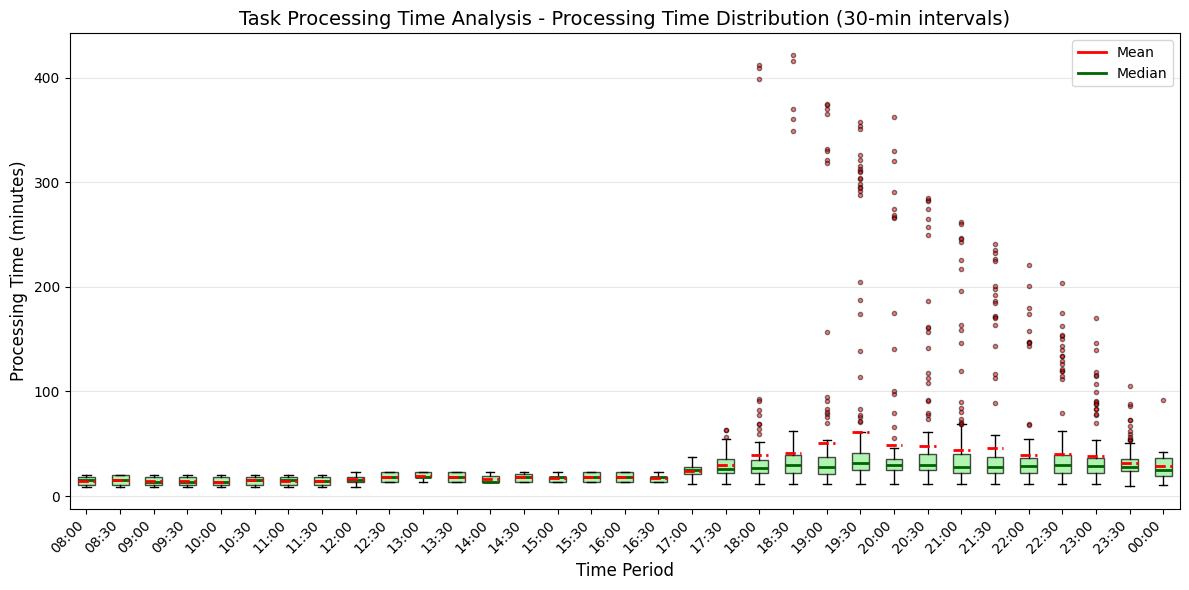

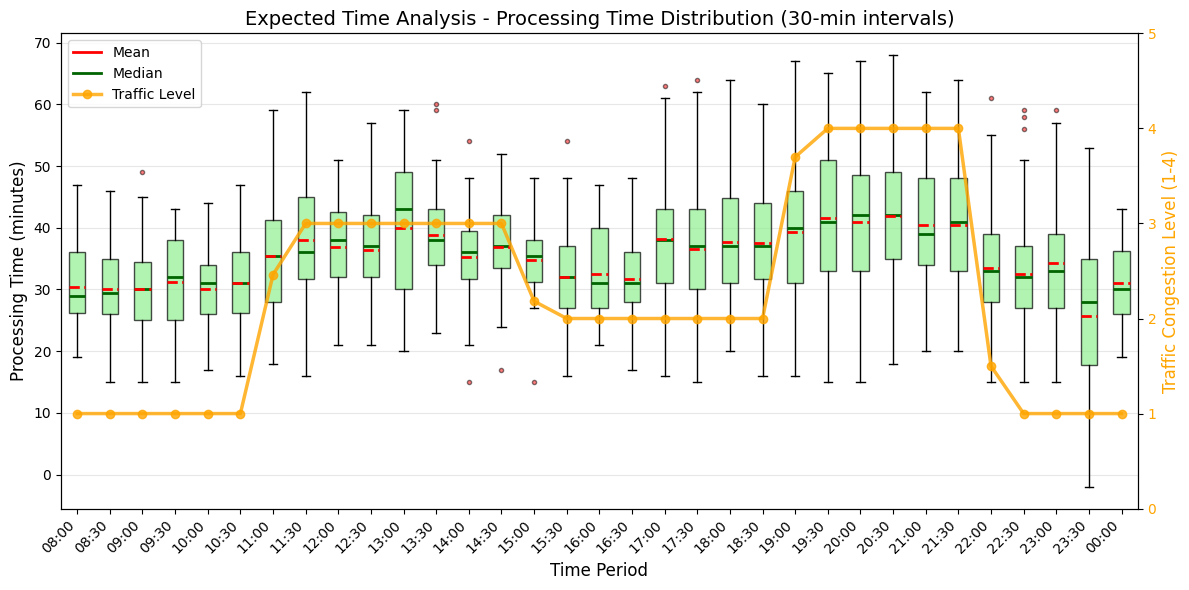

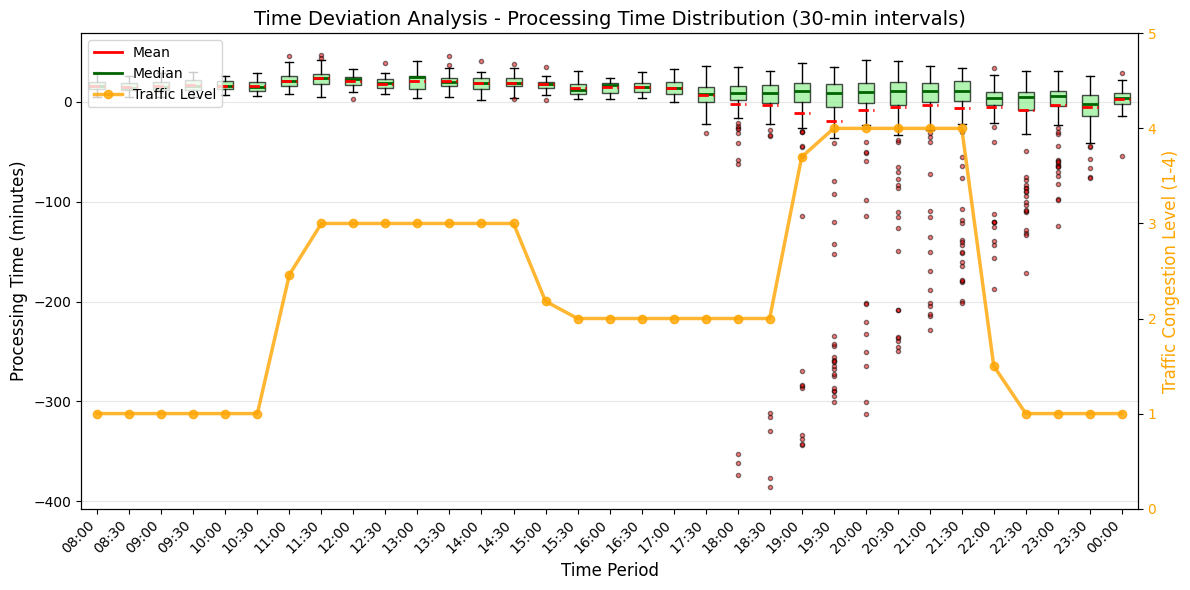

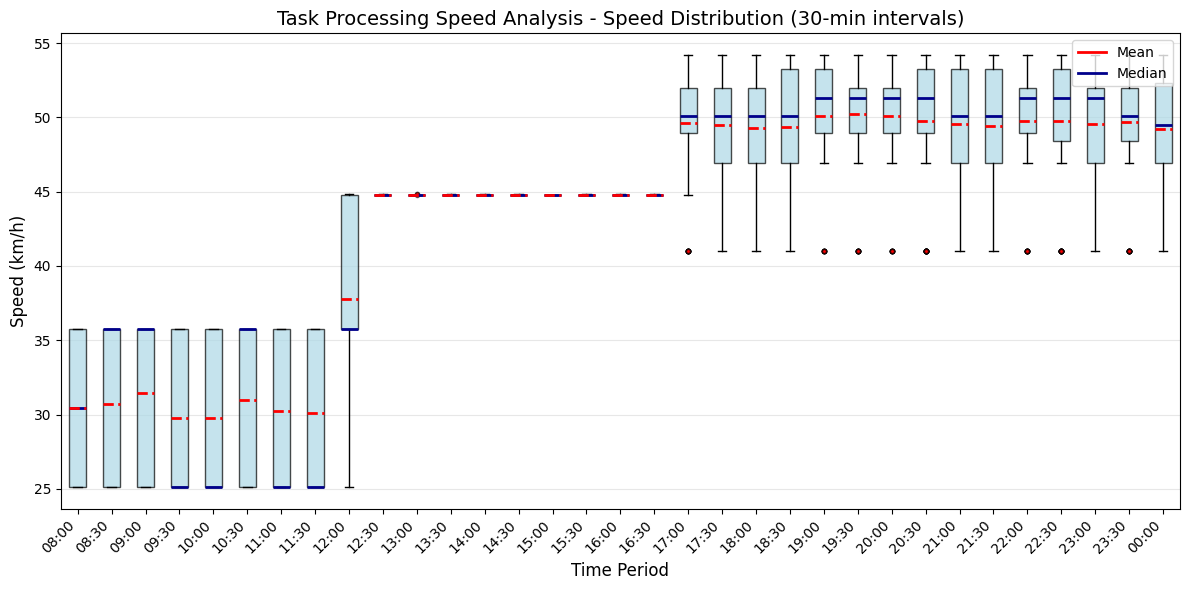

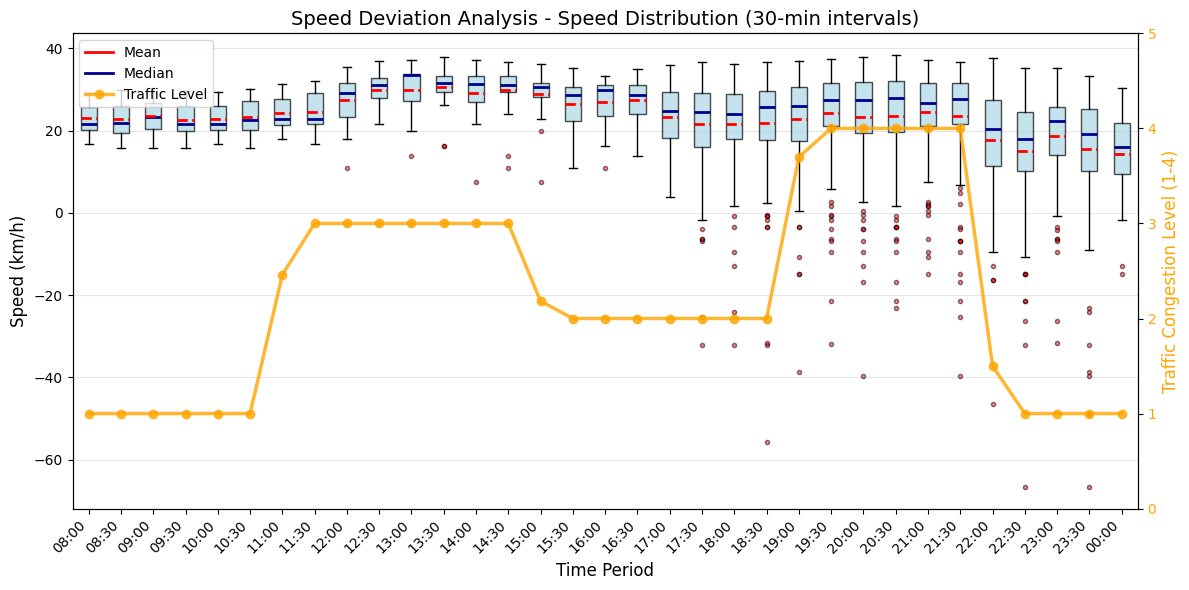

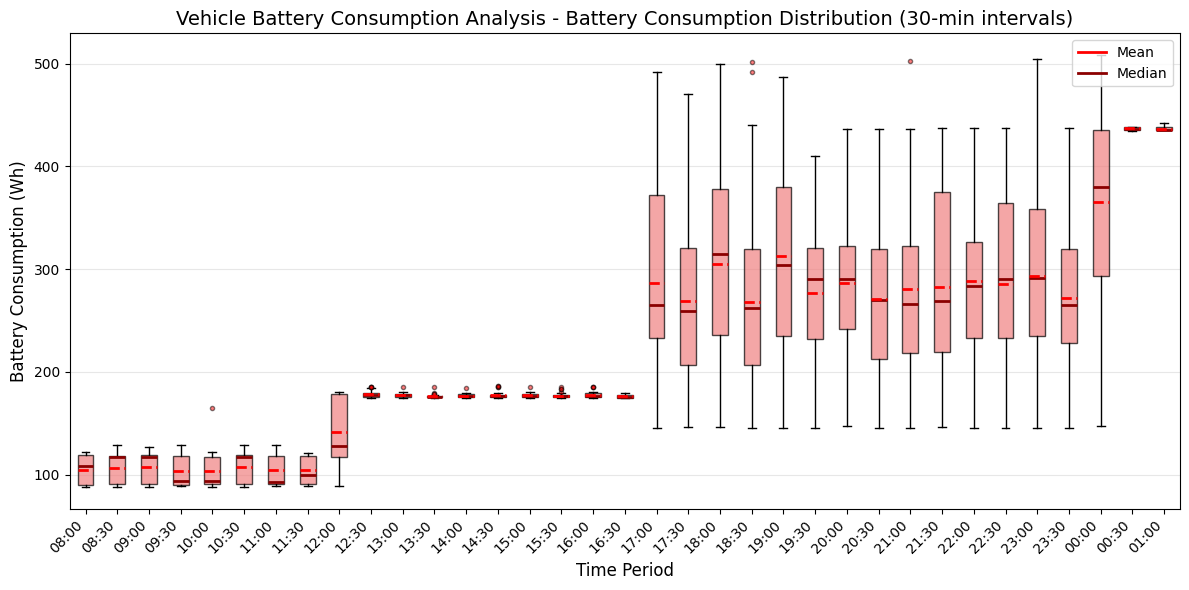

In [122]:
# Run Optimal Distance Assignment Strategy simulation
milp_sim = MILPDroneAssignmentStrategy(DRONE_COUNT, waiting_time=WAITING_TIME)
milp_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT, batch_size=BATCH_SIZE)
p_milp = SimPlot(milp_sim, EXPECT_CSV_FILE)
p_milp.task_processing_times()
p_milp.expected_time_analysis()
p_milp.deviation_in_time_taken()
p_milp.task_speed()
p_milp.deviation_speed()
p_milp.battery_usage()
p_milp.show()